In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

### Аналитическое решение для функции потерь

In [3]:
class LinReg:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        n, m = X.shape
        
        X_train = X
        # встроенный bias
        X_train = np.hstack([X_train, np.ones((n,1))])
        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y
        
        return self
    
    def predict(self, X):
        n, m = X.shape
        X_train = np.hstack([X, np.ones((n, 1))])
        y_pred = X_train @ self.w
        return y_pred
    
    def get_weights(self):
        return self.w

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
def lin_function(x):
    return 5 * x + 3

In [6]:
X = np.linspace(-3, 8, 70)
y = lin_function(X) + np.random.randn(70) * 4
X = X.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [7]:
def plot_lin_reg(y_pred):
    plt.figure(figsize=(14,9))
    plt.scatter(x_train, y_train, label='train', c='b')
    plt.scatter(x_test, y_test, label='test', c='orange')
    plt.plot(X, lin_function(X), label='actual', c='g')
    plt.plot(x_test, y_pred, label='predicted', c='cyan', linestyle=':')
    plt.grid()
    plt.legend()

In [8]:
lin_reg = LinReg()
lin_reg.fit(x_train, y_train)
preds = lin_reg.predict(x_test)
w = lin_reg.get_weights()
w

array([5.0213247 , 2.38192523])

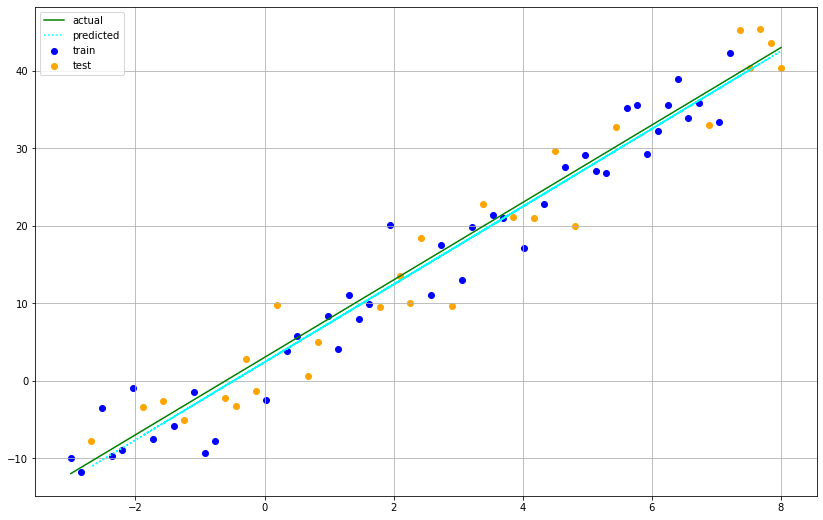

In [9]:
plot_lin_reg(preds)

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
sk_reg = LinearRegression()
sk_reg.fit(x_train, y_train)
preds = sk_reg.predict(x_test)
sk_reg.coef_, sk_reg.intercept_

(array([5.0213247]), 2.381925226134923)

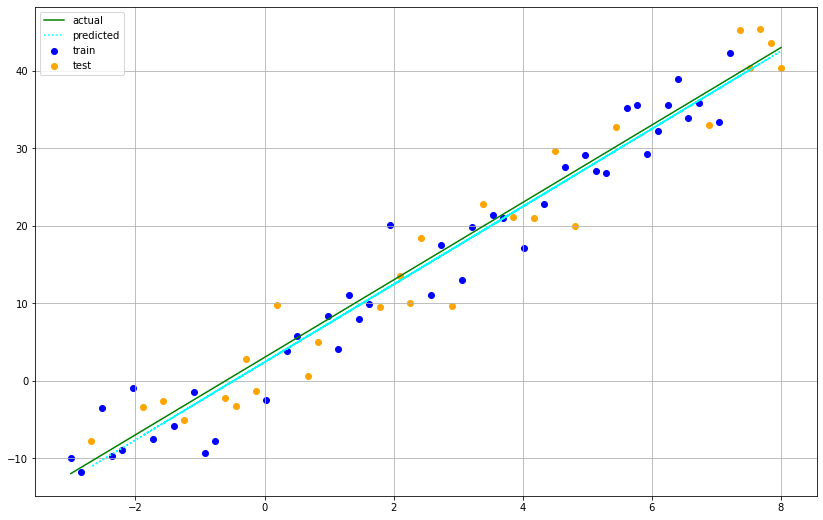

In [12]:
plot_lin_reg(preds)

### Градиентный спуск

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
class GradLinRed(LinReg):
    EPS = 0.001
    
    def __init__(self):
        super().__init__()
        self.w = None
        
    def fit(self, X, y, learning_rate=0.01, max_iter=500):
        n, m = X.shape
        m += 1 # встроенный bias
        if self.w is None:
            self.w = np.random.randn(m)
        X_train = np.hstack([X, np.ones((n, 1))])
        self.loss = []
        for i in range(max_iter):
            y_pred = self.predict(X)
            mse = mean_squared_error(y_pred, y)
            if i > 3 and abs(self.loss[-1] - self.loss[-2]) < self.EPS:
                print('iter stoped on', i)
                break
            self.loss.append(mse)
            grad = self._calc_gradient(X_train, y, y_pred)
            
            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"
            self.w -= learning_rate * grad
            
        return self
    
    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * X.T @ (y_pred - y)[:, np.newaxis]
        grad = grad / len(y)
        grad = grad.reshape(-1)
        return grad
    
    def get_loss(self):
        return self.loss

In [15]:
grad_reg = GradLinRed()
grad_reg.fit(x_train, y_train)
preds = grad_reg.predict(x_test)
w = grad_reg.get_weights()
loss = grad_reg.get_loss()
w

iter stoped on 132


array([5.05918206, 2.13996282])

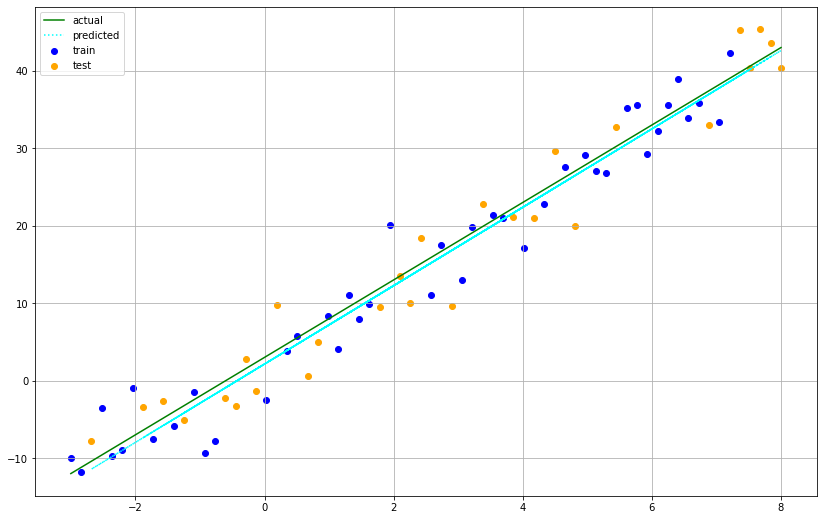

In [16]:
plot_lin_reg(preds)

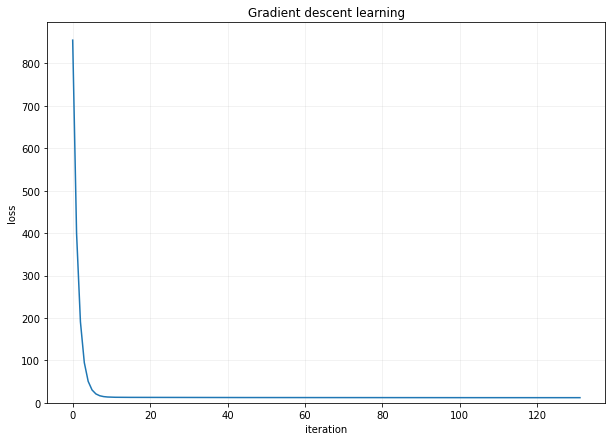

In [17]:
plt.figure(figsize=(10, 7))

plt.plot(loss)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

### SGD

In [18]:
class SGDLinReg(GradLinRed):
    def __init__(self, batch_size=32):
        super().__init__()
        self.w = None
        self.batch_size = batch_size
        
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.batch_size)
        
        grad = 2 * X[inds].T @ (y_pred[inds] - y[inds]).reshape(-1, 1)
        grad /= self.batch_size
        grad = grad.reshape(-1)
        return grad

In [19]:
sgd_reg = SGDLinReg()
sgd_reg.fit(x_train, y_train)
preds = sgd_reg.predict(x_test)
w = sgd_reg.get_weights()
loss = sgd_reg.get_loss()
w

iter stoped on 34


array([4.92320775, 2.92077791])

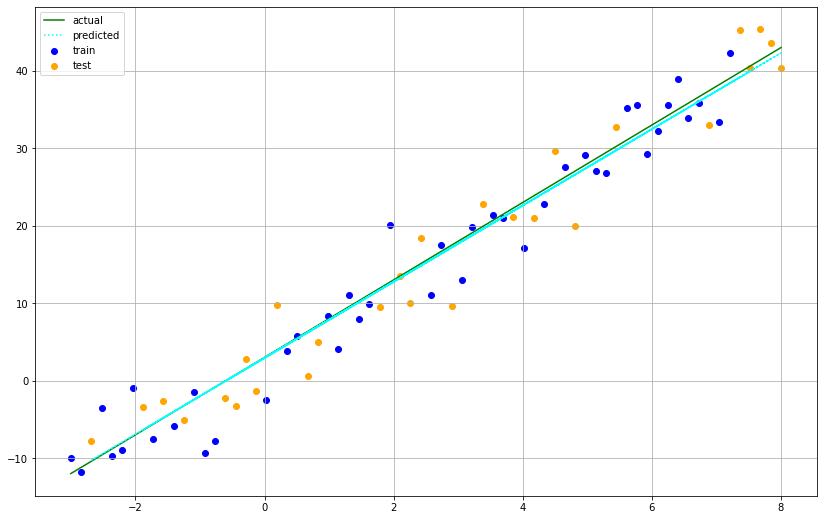

In [20]:
plot_lin_reg(preds)

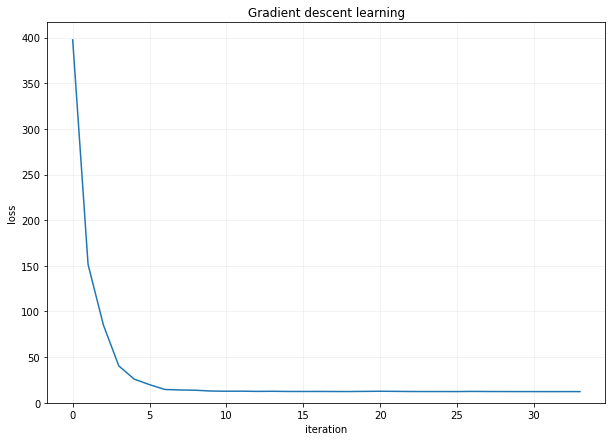

In [21]:
plt.figure(figsize=(10, 7))

plt.plot(loss)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

iter stoped on 33
iter stoped on 31


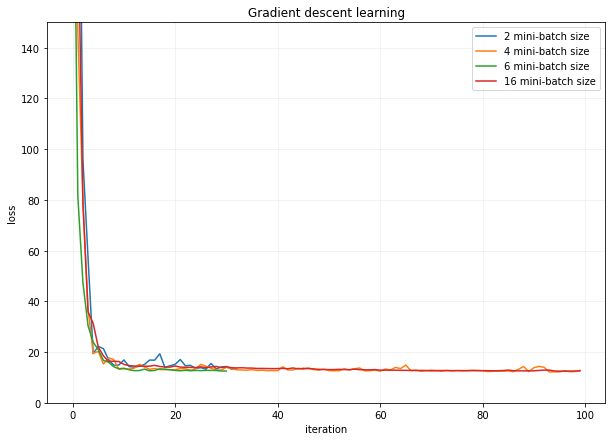

In [22]:
plt.figure(figsize=(10, 7))

for batch in [2, 4, 6, 16]:
    l = SGDLinReg(batch_size=batch).fit(x_train, y_train, max_iter=100).get_loss()
    plt.plot(l, label=f'{batch} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()

### Логистическая регрессия для бинарной классификации

In [23]:
class LogReg:
    def __init__(self):
        self.w = None
        
    def _logit(self, x, w):
        return np.dot(x, w)
    
    def _sigmoid(self, x):
        # может быть переполнение значения из-за большого значения аргумента
        # нужно нормировать входные данные
        return 1.0 / (1.0 + np.exp(-x))
    
    def fit(self, X, y, max_iter=600, learning_rate=0.1):
        n, m = X.shape
        m += 1
        if self.w is None:
            self.w = np.random.randn(m)
            
        self.loss = []
        X_train = np.hstack([X, np.ones((n,1))]) # встроенный bias
        for i in range(max_iter):
            y_pred = self._sigmoid(self._logit(X_train, self.w))
            grad = self._calc_gradient(X_train, y, y_pred)
            self.w -= learning_rate * grad
            self.loss.append(self._clip_loss(y, y_pred))
        return self
    
    
    def _calc_gradient(self, X, y, y_pred):
        grad = np.dot(X.T, (y_pred - y)) / len(y)
        return grad
    
    def _clip_loss(self, y, y_pred):
        y_pred = np.clip(y, 1e-8, 1-1e-8)
        return np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) # logloss
    
    def predict_proba(self, X):
        n, m = X.shape
        X_train = np.hstack([X, np.ones((n, 1))])
        return self._sigmoid(self._logit(X_train, self.w))
    
    def predict(self, X, threshold=0.5):
        predicted = self.predict_proba(X)
        return np.array([1 if i >= threshold else 0 for i in predicted])
    
    def get_weights(self):
        return self.w

In [24]:
class SGDLogReg(LogReg):
    def __init__(self, batch_size=32):
        super().__init__()
        self.w = None
        self.batch_size = batch_size
    
    
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.batch_size)
        grad = np.dot(X[inds].T, (y_pred[inds] - y[inds])) / self.batch_size
        return grad

In [25]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [26]:
x = load_breast_cancer().data
y = load_breast_cancer().target

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [28]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [29]:
clf = LogReg()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

In [30]:
accuracy_score(y_test, preds)

0.986013986013986

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
clf = LogisticRegression(solver='liblinear')
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
accuracy_score(y_test, preds)

0.9790209790209791

In [33]:
clf = SGDLogReg()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
accuracy_score(y_test, preds)

0.986013986013986

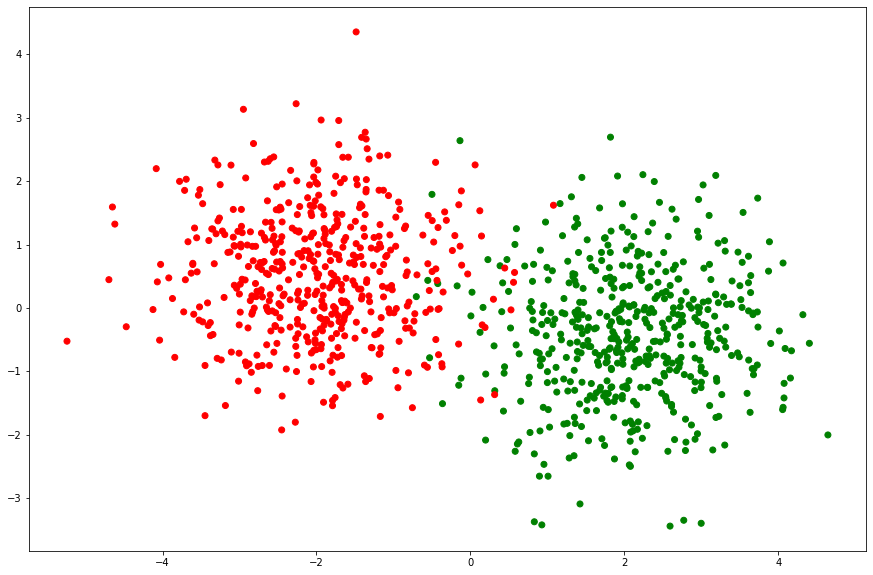

In [34]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[2,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [35]:
clf = LogReg()
clf.fit(X, y)
w = clf.get_weights()

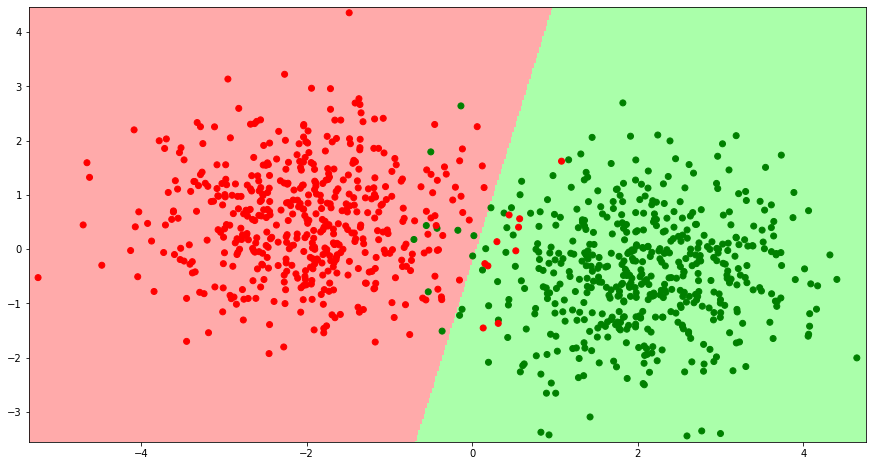

In [36]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

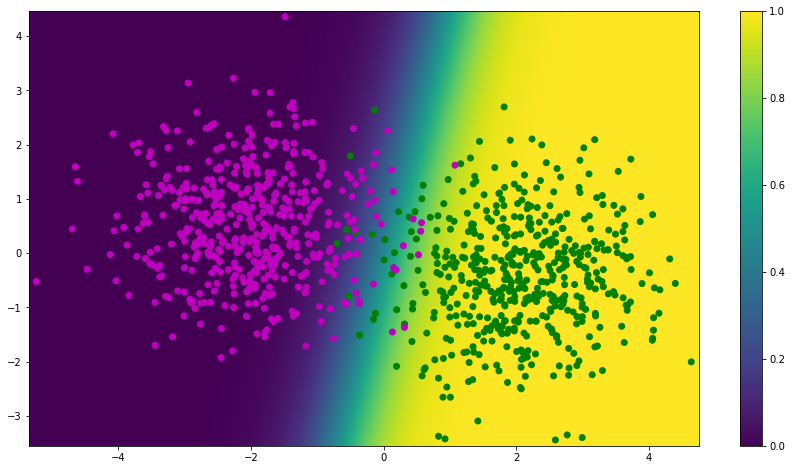

In [37]:
colors = ("magenta", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])


plt.figure(figsize=(15,8))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'), shading='auto')

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.colorbar()
plt.show()

In [38]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [39]:
x = load_iris().data
y = load_iris().target

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [42]:
logit = LogisticRegression(solver='liblinear')
logit.fit(x_train, y_train)
preds = logit.predict(x_test)
preds == y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### Softmax Regression для многоклассовой классификации

https://zen.yandex.ru/media/id/602ce00c6cc0a626e7699094/softmax-regression-multiklassovaia-klassifikaciia-s-tochnostiu-91-6087bdb731d7e506c008eaa2

In [43]:
from sklearn.metrics import classification_report

In [44]:
class SoftmaxRegression:
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, max_iter=600, learning_rate=0.01):
        c = len(np.unique(y)) # число классов
        n, m = X.shape
        m += 1
        if self.w is None:
            self.w = np.random.randn(m, c)
            
        self.loss = []
        X_train = np.hstack([X, np.ones((n,1))])
        for i in range(max_iter):
            y_pred = self._softmax(self._logit(X_train, self.w))
            y_hot = self._one_hot(y, c)
            
            grad = self._calc_gradient(X_train, y_hot, y_pred)
            
            self.w -= learning_rate * grad
            loss = -np.mean(np.log(y_pred[np.arange(len(y)), y]))
            self.loss.append(loss)
        return self
    
    def _calc_gradient(self, X, y, y_pred):
        grad = np.dot(X.T, (y_pred - y)) / len(y_pred)
        return grad
    
    def _logit(self, x, w):
        return np.dot(x, w)
    
    def _softmax(self, z):
        exp = np.exp(z - np.max(z))
        for i in range(len(z)):
            exp[i] /= np.sum(exp[i])
        return exp
    
    def _one_hot(self, y, c):
        # c--> Number of classes.
        # A zero matrix of size (m, c)
        y_hot = np.zeros((len(y), c))
        # Putting 1 for column where the label is,
        # Using multidimensional indexing.
        y_hot[np.arange(len(y)), y] = 1
        return y_hot
    
    def predict_proba(self, X):
        n, m = X.shape
        X_train = np.hstack([X, np.ones((n, 1))])
        return self._softmax(self._logit(X_train, self.w))
    
    def predict(self, X):
        predicted = self.predict_proba(X)
        return np.argmax(predicted, axis=1)
    
    def get_weights(self):
        return self.w
    
    def get_loss(self):
        return self.loss

In [45]:
class SGDSoftmaxReg(SoftmaxRegression):
    def __init__(self, batch_size=32):
        super().__init__()
        self.w = None
        self.batch_size = batch_size
    
    
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.batch_size)
        grad = np.dot(X[inds].T, (y_pred[inds] - y[inds])) / self.batch_size
        return grad

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.82      0.90        11
           2       0.86      1.00      0.92        12

    accuracy                           0.95        38
   macro avg       0.95      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38



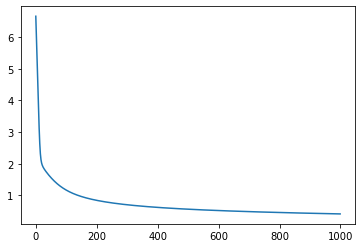

In [46]:
soft = SoftmaxRegression()
soft.fit(x_train, y_train, max_iter=1000)
preds = soft.predict(x_test)
plt.plot(soft.get_loss())
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.73      0.73      0.73        11
           2       0.75      0.75      0.75        12

    accuracy                           0.84        38
   macro avg       0.83      0.83      0.83        38
weighted avg       0.84      0.84      0.84        38



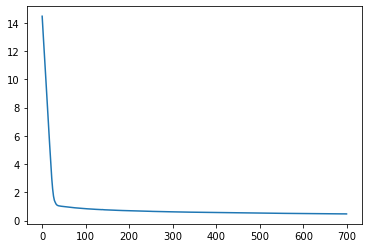

In [47]:
soft = SGDSoftmaxReg(batch_size=128)
soft.fit(x_train, y_train, max_iter=700)
preds = soft.predict(x_test)
plt.plot(soft.get_loss())
print(classification_report(y_test, preds))

In [48]:
soft = LogisticRegression(solver='liblinear')
soft.fit(x_train, y_train)
preds = soft.predict(x_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



## ElasticLogitRegression

Здесь не будет отдельно Lasso и Ridge моделей, поскольку их можно получить из ElasticNet, зануляя коэффициенты регуляризации

In [49]:
class ElasticLogReg(LogReg):
    def __init__(self, l1_coef, l2_coef):
        super().__init__()
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None
        
    def _calc_gradient(self, X, y, y_pred):
        grad_basis = np.dot(X.T, (y_pred - y)) / len(y)
        grad_l1 = self.l1_coef * np.sign(self.w)
        grad_l2 = self.l2_coef * self.w * 2
        grad_l1[-1] = 0 # последний компонент - это bias
        grad_l2[-1] = 0 # последний компонент - это bias
        return grad_basis + grad_l1 + grad_l2

In [50]:
x = load_breast_cancer().data
y = load_breast_cancer().target
noise = np.random.random((len(x),30))
x = np.hstack([x, noise])

In [51]:
x.shape

(569, 60)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [53]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [54]:
elastic = ElasticLogReg(0.0, 0.2)
elastic.fit(x_train, y_train, learning_rate=0.01, max_iter=1000)
preds = elastic.predict(x_test)
accuracy_score(y_test, preds)

0.965034965034965

In [55]:
elastic.w.round(2)

array([-0.18, -0.15, -0.17, -0.16, -0.07, -0.09, -0.15, -0.16, -0.07,
        0.04, -0.1 ,  0.02, -0.11, -0.12,  0.02, -0.01,  0.03, -0.05,
        0.02,  0.06, -0.15, -0.16, -0.19, -0.16, -0.11, -0.09, -0.15,
       -0.2 , -0.12, -0.06,  0.01, -0.  ,  0.05, -0.01, -0.  ,  0.01,
        0.02, -0.01,  0.01,  0.04,  0.03, -0.  , -0.01, -0.01, -0.01,
       -0.02, -0.  , -0.01, -0.03, -0.02, -0.01, -0.03, -0.01,  0.01,
        0.01,  0.02, -0.04, -0.03,  0.04, -0.01,  0.71])

In [56]:
class ElasticSoftmaxReg(SoftmaxRegression):
    def __init__(self, l1_coef, l2_coef):
        super().__init__()
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None
        
    def _calc_gradient(self, X, y, y_pred):
        grad_basis = np.dot(X.T, (y_pred - y)) / len(y)
        grad_l1 = self.l1_coef * np.sign(self.w)
        grad_l2 = self.l2_coef * self.w * 2
        grad_l1[-1] = 0 # последний компонент - это bias
        grad_l2[-1] = 0 # последний компонент - это bias
        return grad_basis + grad_l1 + grad_l2

In [57]:
x = load_iris().data
y = load_iris().target

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.73      0.84        11
           2       0.80      1.00      0.89        12

    accuracy                           0.92        38
   macro avg       0.93      0.91      0.91        38
weighted avg       0.94      0.92      0.92        38



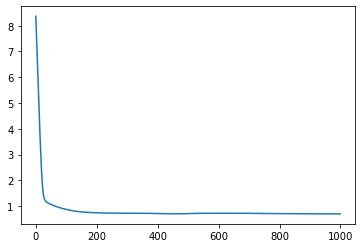

In [59]:
elastic = ElasticSoftmaxReg(0.3, 0)
elastic.fit(x_train, y_train, max_iter=1000)
preds = elastic.predict(x_test)
plt.plot(elastic.get_loss())
print(classification_report(y_test, preds))

In [60]:
elastic.get_weights().round(2)

array([[ 0.  , -0.  , -0.  ],
       [ 0.  , -0.  , -0.  ],
       [-0.36, -0.  ,  0.53],
       [ 0.  , -0.  ,  0.  ],
       [ 1.21,  0.38, -2.13]])